# Masked Language Modelling and Sequence Classification with Bert
### HW3 @ DL Course, Dr. Soleymani

*Full Name:* Ehsan Hassanbeygi

*SID:* 402211723

In this notebook, we leverage the "rotten_tomatoes" dataset from HuggingFace, containing movie reviews from Rotten Tomatoes. Our objectives are twofold:


1.   Perform Masked Language Modeling (MLM) on the training portion of provided dataset.
2.   Construct a classifier to discern between positive and negative reviews.

To achieve these goals, we employ a customized smaller version of BERT. This choice facilitates training and computation, ensuring efficiency and feasibility.

In [1]:
# Install necessary packages
# %%capture
!pip install datasets
!pip install transformers
!pip install evaluate
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 8.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.28.0
    Uninstalling accelerate-0.28.0:
      Successfully uninstalled accelerate-0.28.0


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from datasets import load_dataset
import matplotlib.pyplot as plt

In [3]:
# Set up basic configurations for training
batch_size = 32
learning_rate = 1e-5
num_epoch = 5
num_labels = 2
np.random.seed(42)
torch.manual_seed(42)

# Select device for training (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Load the Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
dataset

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In all subsequent sections, we utilize the pre-trained BERT tokenizer. Thus, we begin by importing and initializing it here.

In [5]:
# Import BertTokenizer from the transformers library
from transformers import BertTokenizer

# Load the pre-trained BertTokenizer model 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

We will utilize this configuration for the BERT model in subsequent sections.

In [6]:
# Import BertConfig from the transformers library
from transformers import BertConfig

# Define configuration parameters for the BERT model
config = BertConfig(
    hidden_size=384,
    vocab_size=tokenizer.vocab_size,
    num_hidden_layers=6,
    num_attention_heads=6,
    intermediate_size=1024,
    max_position_embeddings=256,
)

# 1 Masked Language Modeling

Masked Language Modeling (MLM) is a fundamental task in natural language processing (NLP) where a `head` is placed on top of a `BERT` (Bidirectional Encoder Representations from Transformers) model to `perform predictions`.
In MLM, certain words or tokens in a sentence are randomly masked or replaced with a special token, and the model is trained to predict the original words based on the context of the surrounding tokens. The objective of MLM is to encourage the model to learn contextual relationships between words and understand the overall structure and semantics of the language. During training, the model receives input sequences with masked tokens and is trained to generate the correct tokens for the masked positions. MLM serves as a crucial pre-training step in learning rich contextual representations of words, which can be transferred to downstream tasks such as text classification, named entity recognition, and question answering.

![](https://editor.analyticsvidhya.com/uploads/22971fig-3.png)

## 1.1 Dateset preparation for MLM

In [7]:
# Define a function to preprocess text data for masked language modeling (MLM)
def mlm_map_function(rows):
    # Tokenize the text with specified tokenizer parameters
    input_info = tokenizer(
        rows["text"],
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    return {**input_info, "labels": input_info["input_ids"]}


# Apply the mlm_map_function to the dataset for masked language modeling (MLM)
mlm_dataset = dataset.map(
    mlm_map_function,
    batched=True,
    num_proc=2,
    remove_columns=dataset["train"].column_names,
)

Map (num_proc=2):   0%|          | 0/8530 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1066 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1066 [00:00<?, ? examples/s]

In [8]:
# Import DataCollatorForLanguageModeling from transformers
from transformers import DataCollatorForLanguageModeling

# Create a data collator for MLM training
collate_fn = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

# Create a DataLoader for MLM training
train_dataloader = torch.utils.data.DataLoader(
    mlm_dataset["train"], collate_fn=collate_fn, batch_size=batch_size
)

2024-04-12 14:47:49.622158: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 14:47:49.622255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 14:47:49.737058: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1.2 BertModel + MLMHead + Custom trainer

In [9]:
class MLMHead(nn.Module):
    """
    Multi-Layer Perceptron (MLP) head for Masked Language Modeling (MLM) task.

    Parameters:
        bert_model (torch.nn.Module): BERT model.
        hidden_size (int): Size of the hidden layers in the MLP head. Default is 384.
        vocab_size (int): Size of the vocabulary. Default is 30522.
    """

    def __init__(self, bert_model, hidden_size=384, vocab_size=30522):
        super(MLMHead, self).__init__()
        ######################  TODO  ########################
        ######################  TODO  ########################

        self.embedder = bert_model
        self.dense = nn.Linear(bert_model.config.hidden_size, hidden_size)
        self.activation = nn.ReLU()
        self.layernorm = nn.LayerNorm(hidden_size)
        self.decoder = nn.Linear(hidden_size, vocab_size)

        ######################  TODO  ########################
        ######################  TODO  ########################

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the MLMHead module.

        Parameters:
            input_ids (torch.Tensor): Tensor containing input token IDs.
            attention_mask (torch.Tensor): Tensor containing attention mask.

        Returns:
            torch.Tensor: Output tensor of the MLM head.
        """
        ######################  TODO  ########################
        ######################  TODO  ########################

        # Use the BERT model to get the last hidden states
        last_hidden_states = self.embedder(
            input_ids=input_ids, attention_mask=attention_mask
        ).last_hidden_state

        # Pass the last hidden states through the MLP head layers
        x = self.dense(last_hidden_states)
        x = self.activation(x)
        x = self.layernorm(x)
        x = self.decoder(x)

        return x

        ######################  TODO  ########################
        ######################  TODO  ########################

In [10]:
from transformers import BertModel

bert = BertModel(config)
######################  TODO  ########################
######################  TODO  ########################

mlm_model = MLMHead(bert)
optimizer = optim.AdamW(mlm_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

######################  TODO  ########################
######################  TODO  ########################

In [11]:
######################  TODO  ########################
######################  TODO  ########################
import time


# works for both train and test
def run_epoch(
    model,
    optimizer,
    data_loader,
    criterion,
    device,
    results,
    score_funcs=None,
    prefix="",
    desc=None,
):
    running_loss = []
    start = time.time()
    for batch in tqdm(data_loader, desc=desc, leave=False):
        input_ids = batch["input_ids"].to(device)
        att_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        #         inputs = inputs.to(device)
        #         labels = labels.to(device)

        y_hat = model(input_ids, att_mask)
        #         print("y_hat shape:\n", y_hat.shape)
        #         print("labels shape:\n", labels.shape)

        #         sequence_len = y_hat.shape[1]
        #         for k in range(sequence_len):
        #             y_hat_sliced = y_hat[:, k, :]
        #             labels_sliced = labels[:, k]
        #             if k == 0:
        #                 loss = criterion(y_hat_sliced, labels_sliced)
        #             else:
        #                 loss += criterion(y_hat_sliced, labels_sliced)

        y_hat = y_hat.permute(0, 2, 1)
        loss = criterion(y_hat, labels)
        #         print("y_hat_permuted shape: ", y_hat_permuted.shape)
        #         print("labels shape: ", labels.shape)
        #         print("loss shape: ", loss.shape)
        #         loss = torch.sum(loss, axis=1)
        #         print("loss shape: ", loss.shape)
        #         print("loss.item()= ", loss.item())

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Store metrics
        running_loss.append(loss.item())

    end = time.time()
    results[prefix + " loss"].append(np.mean(running_loss))
    return end - start


def train_network(
    model,
    criterion,
    train_loader,
    val_loader=None,
    test_loader=None,
    score_funcs=None,
    epochs=50,
    device="cpu",
    checkpoint_file=None,
    lr_scheduler=None,
    optimizer=None,
    disable_tqdm=False,
    log_items=(),
):
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    if test_loader is not None:
        to_track.append("test loss")
    if score_funcs is not None:
        for eval_score in score_funcs:
            to_track.append("train " + eval_score)
            if val_loader is not None:
                to_track.append("val " + eval_score)
            if test_loader is not None:
                to_track.append("test " + eval_score)

    # Initialization
    total_train_time = 0
    results = {}
    for item in to_track:
        results[item] = []

    if optimizer == None:
        optimizer = torch.optim.AdamW(model.parameters())

    model.to(device)
    pbar = tqdm(range(epochs), desc="Epoch", disable=disable_tqdm)
    for epoch in pbar:
        model = model.train()

        total_train_time += run_epoch(
            model,
            optimizer,
            train_loader,
            criterion,
            device,
            results,
            score_funcs=score_funcs,
            prefix="train",
            desc="Training",
        )

        results["epoch"].append(epoch)
        results["total time"].append(total_train_time)

        # Predict the validation set
        if val_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(
                    model,
                    optimizer,
                    val_loader,
                    criterion,
                    device,
                    results,
                    score_funcs=score_funcs,
                    prefix="val",
                    desc="Validating",
                )

        if lr_scheduler is not None:
            if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_scheduler.step(results["val loss"][-1])
            else:
                lr_scheduler.step()

        # Predict the validation set
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(
                    model,
                    optimizer,
                    test_loader,
                    criterion,
                    device,
                    results,
                    score_funcs=score_funcs,
                    prefix="test",
                    desc="Testing",
                )

        log_postfix = {}
        log_str = f"Epoch [{epoch+1}]: "
        for log_item in log_items:
            log_postfix[log_item] = results[log_item][-1]
            log_str += f"{log_item}: {results[log_item][-1]:.4f}, "

        pbar.set_postfix(log_postfix)
        print(log_str)

    if checkpoint_file is not None:
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "results": results,
            },
            checkpoint_file,
        )

    return results


results = train_network(
    mlm_model,
    criterion,
    train_dataloader,
    optimizer=optimizer,
    epochs=num_epoch,
    device=device,
    log_items=("train loss",),
)

######################  TODO  ########################
######################  TODO  ########################

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch [1]: train loss: 9.4375, 


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch [2]: train loss: 8.3320, 


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch [3]: train loss: 7.7036, 


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch [4]: train loss: 7.3448, 


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch [5]: train loss: 7.1332, 


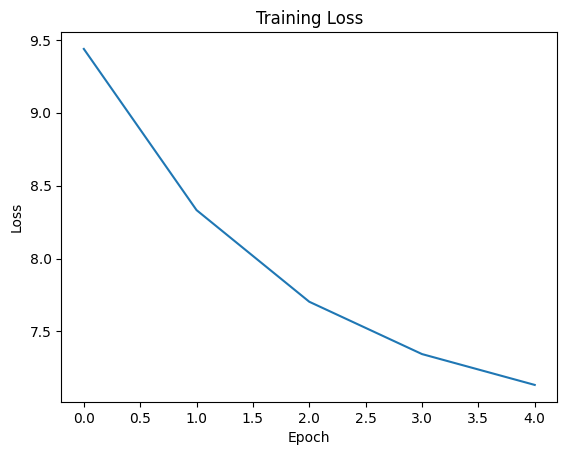

In [12]:
# Plot the losse for every batch in training process
plt.plot(results["train loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

## 1.3 BertForMaskedLM + huggingface trainer

[HuggingFace library](http://huggingface.co/) has built a nice API for NLP tasks around the transformers. To get familiar with this comrehensive library, In this section you are asked to use the huggingface `Trainer`, `Dataset`, and `BertForMaskedLM` to do what we did above again.

Feel free to refer to the library documentation to learn about these modules.

You should utilize the prepared dataset and configuration from earlier.

In [13]:
######################  TODO  ########################
######################  TODO  ########################

from transformers import BertForMaskedLM, Trainer, TrainingArguments

bert_mlm_model = BertForMaskedLM(config)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    num_train_epochs=num_epoch,
    logging_steps=len(train_dataloader),  # Log per epoch
    report_to=[],  # Disable wandb logging
)

trainer = Trainer(
    model=bert_mlm_model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=mlm_dataset["train"],
)

trainer.train()

######################  TODO  ########################
######################  TODO  ########################

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
267,9.476600
534,8.567400
801,8.078400
1068,7.842200
1335,7.750700


TrainOutput(global_step=1335, training_loss=8.3430684178956, metrics={'train_runtime': 174.3986, 'train_samples_per_second': 244.555, 'train_steps_per_second': 7.655, 'total_flos': 277250297932800.0, 'train_loss': 8.3430684178956, 'epoch': 5.0})

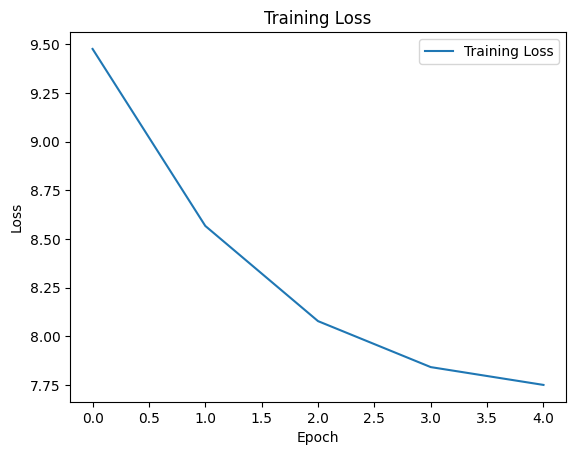

In [14]:
train_losses = [entry["loss"] for entry in trainer.state.log_history[:-1]]

plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

In [15]:
break_point = 

SyntaxError: invalid syntax (3987522075.py, line 1)

# 2 Sequence Classification

When you look at how `BERT encodes` text, you'll see that it creates a `vector` for each word in the input sentence. But for basic classification tasks, we don't need all those individual word vectors.

Instead, we can just use the `first token's vector` because it captures the overall meaning of the sentence. BERT conveniently provides this vector for us in a special variable called `pooler_output`. So, in our classifier model, we'll use this pooler_output as the input for our classification head.
![BERT pooler output](https://miro.medium.com/max/1100/1*Or3YV9sGX7W8QGF83es3gg.webp)

## 2.1 Dataset preparation for sequence classification

In [ ]:
# Define a function to preprocess text data for classification
def cls_map_function(rows):
    # Tokenize the text with specified tokenizer parameters
    input_info = tokenizer(rows['text'], truncation=True, max_length=128, padding=True)
    return {
        **input_info,
        'labels': rows['label']
        }

# Apply the cls_map_function to the dataset for classification
cls_dataset = dataset.map(cls_map_function, batched=True, num_proc=2, remove_columns=dataset['train'].column_names)

In [ ]:
# Import DataCollatorWithPadding from transformers
from transformers import DataCollatorWithPadding

# Create a data collator with padding
col_fn = DataCollatorWithPadding(
    tokenizer, return_tensors='pt', padding='longest',
)

# Create a DataLoader for training data
train_loader = torch.utils.data.DataLoader(
    cls_dataset['train'],
    batch_size=batch_size,
    collate_fn=col_fn,
    shuffle=True
)

# Create a DataLoader for test data
test_loader = torch.utils.data.DataLoader(
    cls_dataset['test'],
    batch_size=batch_size,
    collate_fn=col_fn,
)

## 2.2 BertModel + ClassifierHead + Custom trainer

In [ ]:
class ClassifierHead(nn.Module):
    """
    Classifier head for classification tasks.

    Parameters:
        embedding_model (torch.nn.Module): bert model.
        num_classes (int): Number of classes for classification. Default is 2.
    """

    def __init__(self, embedding_model, num_classes=2):
        super().__init__()
        ######################  TODO  ########################
        ######################  TODO  ########################
        # construct layers and structure of the network
        self.embedder =
        self.classifier =
        self.sigmoid =
        ######################  TODO  ########################
        ######################  TODO  ########################

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the ClassifierHead module.

        Parameters:
            input_ids (torch.Tensor): Tensor containing input token IDs.
            attention_mask (torch.Tensor): Tensor containing attention mask.

        Returns:
            torch.Tensor: Output tensor of the classifier head.
        """
        ######################  TODO  ########################
        ######################  TODO  ########################
        # implement the forward pass of your model.
        # the sentence, the get the embeddings from your language
        # model, then use the `pooler_output` for your classifier
        # layer.

        ######################  TODO  ########################
        ######################  TODO  ########################
        return output

In [ ]:
# Define the function to compute metrics
import evaluate
accuracy = evaluate.load("accuracy")

# Define the BERT model
bert = BertModel(config=config)

# Define the classifier head
cls_model =
optimizer =
criterion =
######################  TODO  ########################
######################  TODO  ########################

In [ ]:
######################  TODO  ########################
######################  TODO  ########################
# implement your training loop and train your model.

######################  TODO  ########################
######################  TODO  ########################

## 2.3 BertForSequenceClassification + Hugginface Trainer

[HuggingFace library](http://huggingface.co/) has built a nice API for NLP tasks around the transformers. To get familiar with this comrehensive library, In this section you are asked to use the huggingface `Trainer`, `Dataset`, and `BertForSequenceClassification` to do what we did above again.

Feel free to refer to the library documentation to learn about these modules.

You should utilize the prepared dataset and configuration from earlier.(You can include any additional required attributes to configuration.)

In [ ]:
######################  TODO  ########################
######################  TODO  ########################

######################  TODO  ########################
######################  TODO  ########################